In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics

import matplotlib.pyplot as plt
import altair as alt


### Prediction of Volume Expansion by Gas Injection

Can we predict volume expansion when a gas is injected into heavy oil emulsion?

Out inputs :
- The type of the gas (CH4 and CO2)
- Water content in the emulsion (as a fraction)
- time elapsed since injection
    
    

our outputs :
- volume expansion,'this notebook'
- IFT, 'this notebook'

In [2]:
# let's read the data
ift_data = pd.read_excel('data/ift_data.xlsx')

In [50]:
# let's explore the data head
ift_data.head()

,Gas,Water_content,time_minutes,volume_ratio,IFT
0,CH4,0.0,0.000050,1.000000,25.08
1,CH4,0.0,14.998333,1.002618,25.12
2,CH4,0.0,30.000000,1.005236,25.16
3,CH4,0.0,45.000000,1.006108,25.17
4,CH4,0.0,60.000000,1.007853,25.21


In [4]:
# quick glmipse into the number of rows
ift_data.info

<bound method DataFrame.info of      Gas  Water_content  time_minutes  volume_ratio    IFT
0    CH4            0.0      0.000050      1.000000  25.08
1    CH4            0.0     14.998333      1.002618  25.12
2    CH4            0.0     30.000000      1.005236  25.16
3    CH4            0.0     45.000000      1.006108  25.17
4    CH4            0.0     60.000000      1.007853  25.21
..   ...            ...           ...           ...    ...
556  CO2            0.7    150.000000      0.978155  19.93
557  CO2            0.7    165.000000      0.979369  19.95
558  CO2            0.7    180.000000      0.974515  19.87
559  CO2            0.7    195.000000      0.976942  19.92
560  CO2            0.7    210.000000      0.973301  19.86

[561 rows x 5 columns]>

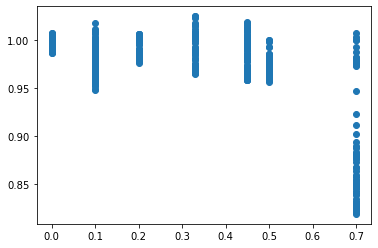

In [51]:
# quick plotting
plt.scatter(ift_data['Water_content'],ift_data['volume_ratio']);

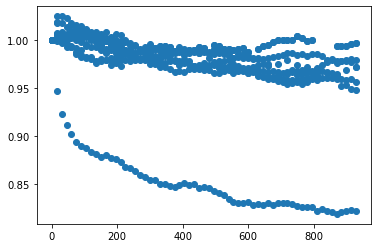

In [6]:
plt.scatter(ift_data['time_minutes'],ift_data['volume_ratio']);

In [74]:
# let's use altair to visualize the effect of water content and time Simultaneously 
alt.Chart(ift_data, title = 'Change in volume with water content over time for CH4 and CO2').mark_circle(size=60).encode(
    alt.X('time_minutes:Q', title = 'Time (minutes)'),
    alt.Y('volume_ratio:Q', scale=alt.Scale(domain=[0.8, 1.05]),title = 'Volume ratio (fraction)' ),
    alt.Color('Gas:N'),
).interactive()

alt.Chart(...)

In [97]:
# let's look at the number of the record in the datset for the type of the Gas

In [92]:
alt.Chart(ift_data, title = 'Data frequency for the type of the gas in the data set').mark_bar().encode(
    alt.Y('Gas:N', title = 'Gas'),
    alt.X('count(Gas):Q' ),
).interactive()

alt.Chart(...)

In [99]:
# these are the input features that we have
# - for x 
ift_data.iloc[:,:3]

,Gas,Water_content,time_minutes
0,CH4,0.0,0.000050
1,CH4,0.0,14.998333
2,CH4,0.0,30.000000
3,CH4,0.0,45.000000
4,CH4,0.0,60.000000
...,...,...,...
556,CO2,0.7,150.000000
557,CO2,0.7,165.000000
558,CO2,0.7,180.000000
559,CO2,0.7,195.000000


In [103]:
# for y 
ift_data.iloc[:,3]

0      1.000000
1      1.002618
2      1.005236
3      1.006108
4      1.007853
         ...   
556    0.978155
557    0.979369
558    0.974515
559    0.976942
560    0.973301
Name: volume_ratio, Length: 561, dtype: float64

### Modeling pipeline : preprocessing, augmenting missing data,hyper-paramters optimization and validation

In [54]:
# let's us first create out X and y for trianing
x= ift_data.iloc[:,:3] # get x
y = ift_data.iloc[:,3] # get y
# splitting the data into train and test model
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, shuffle=True)
# since we have numeric and categorical features we will create a column transformer to transform them seperately

# first transformer for the numeric features
numeric_features = ['Water_content', 'time_minutes']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
# now a taransformer for the categorical features
categorical_features = ['Gas']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# creating a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

ridge_model = Ridge()
# include the preprocessor and the model in one pipeline.
# Now we have a full prediction pipeline.
reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('Regressor', ridge_model)])

# finally we will pass the pipe line to gridsearchcv to find the optimum paramters for the model
param_grid = {
    'Regressor__alpha':[0.1,0.25,0.4],
}
search = GridSearchCV(reg_pipeline,param_grid,cv = 5)

# fitting the model
search.fit(X_train, y_train)

# printing the first parameter
print(search.best_params_)
print("model score on training set: %.3f" % search.score(X_train, y_train))
print("model score on test set: %.3f" % search.score(X_test, y_test))


{'Regressor__alpha': 0.4}
model score on training set: 0.529
model score on test set: 0.543


> Well the model is undefitting, we have high bias, but since the train and test score is similar we note that we have low variance

In [31]:
# let's look at he model paramters
model_intercept = search.best_estimator_['Regressor'].intercept_
model_intercept


0.9734177136645129

In [32]:
model_slopes = search.best_estimator_['Regressor'].coef_
model_slopes


array([-0.02831958, -0.01550238, -0.00407124,  0.00407124])

In [33]:
coeff_parameter = pd.DataFrame(search.best_estimator_['Regressor'].coef_,columns=['Coefficient'])
coeff_parameter

,Coefficient
0,-0.028320
1,-0.015502
2,-0.004071
3,0.004071


In [34]:
# let's evaluate the model peroformance using MSE and MAE

In [35]:
y_pred = search.predict(X_test)

In [36]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.02581717060640939
Mean Squared Error: 0.0010484174998642716
Root Mean Squared Error: 0.03237927577732818


### Model Selection : Trying Gradient boosting

In [37]:
gb_model = GradientBoostingRegressor()
reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('Regressor', gb_model)])
param_grid = {
    'Regressor__learning_rate':[0.1,0.25,0.4],
}
search = GridSearchCV(reg_pipeline, param_grid, n_jobs=-1)

search.fit(X_train, y_train)
search.best_params_
print("model score: %.3f" % search.score(X_test, y_test))
#reg.get_params().keys()

model score: 0.966


In [38]:
y_pred = search.predict(X_test)

In [39]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 0.0037995556140679593
Mean Squared Error: 7.733144579997122e-05
Root Mean Squared Error: 0.008793829984709236


In [40]:
X_test

,Gas,Water_content,time_minutes
466,CO2,0.10,195.0
157,CH4,0.20,555.0
452,CO2,0.00,930.0
449,CO2,0.00,885.0
467,CO2,0.10,210.0
...,...,...,...
508,CO2,0.10,825.0
374,CH4,0.70,615.0
181,CH4,0.20,915.0
485,CO2,0.10,480.0


In [41]:
y_test

466    0.990361
157    0.982226
452    0.997382
449    0.994764
467    0.995181
         ...   
508    0.974699
374    0.828313
181    0.980355
485    0.987952
200    0.975976
Name: volume_ratio, Length: 113, dtype: float64

In [42]:
new_data = X_test.iloc[[0]]
new_data

,Gas,Water_content,time_minutes
466,CO2,0.1,195.0


In [43]:
search.predict(new_data)

array([0.99754915])

In [93]:
new_data.iloc[0,1] = 0.7;

/Users/mosal/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [45]:
new_data


,Gas,Water_content,time_minutes
466,CO2,0.7,195.0


In [46]:
search.predict(new_data)

array([0.97630982])

In [47]:
## saving thee model : 

In [94]:
from joblib import dump, load
dump(search.best_estimator_, 'model.pkl')

['model.pkl']

In [95]:
model = load('model.pkl')

model.predict(new_data)

array([0.94043886])